# Studi Kasus: Prediksi Profitabilitas Menu Restoran
ALI AKBAR QUMAINY (23611121)

## Pemilihan dan Eksplorasi Dataset

**Deskripsi Dataset dan Alasan Pemilihan**

Dataset yang digunakan adalah `restaurant_menu_optimization_data.csv`. Dataset ini dipilih karena sangat cocok untuk tugas klasifikasi *supervised learning*, di mana tujuannya adalah untuk memprediksi variabel target kategorikal (`Profitability`) berdasarkan serangkaian fitur deskriptif dari item menu.


Profitabilitas sebuah item menu (yang diklasifikasikan sebagai Tinggi, Sedang, atau Rendah) dipengaruhi secara signifikan oleh harga, kategori menu, dan kombinasi bahan yang digunakan. 

**Variabel yang Digunakan** 📊

Model ini akan dilatih menggunakan variabel-variabel berikut:
- **Fitur (Input)**: `MenuCategory`, `MenuItem`, `Ingredients`, dan `Price`.
- **Target (Output)**: `Profitability` (High, Medium, Low).

**Analisis Data Eksplorasi (EDA)**

EDA dilakukan untuk mendapatkan pemahaman mendalam tentang data, mencakup visualisasi distribusi setiap variabel untuk mengidentifikasi pola dan hubungan yang dapat mempengaruhi profitabilitas.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from imblearn.over_sampling import SMOTE

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

df = pd.read_csv('restaurant_menu_optimization_data.csv')
df.head()

,RestaurantID,MenuCategory,MenuItem,Ingredients,Price,Profitability
0,R003,Beverages,Soda,['confidential'],2.55,Low
1,R001,Appetizers,Spinach Artichoke Dip,"['Tomatoes', 'Basil', 'Garlic', 'Olive Oil']",11.12,Medium
2,R003,Desserts,New York Cheesecake,"['Chocolate', 'Butter', 'Sugar', 'Eggs']",18.66,High
3,R003,Main Course,Chicken Alfredo,"['Chicken', 'Fettuccine', 'Alfredo Sauce', 'Pa...",29.55,High
4,R002,Main Course,Grilled Steak,"['Chicken', 'Fettuccine', 'Alfredo Sauce', 'Pa...",17.73,Medium


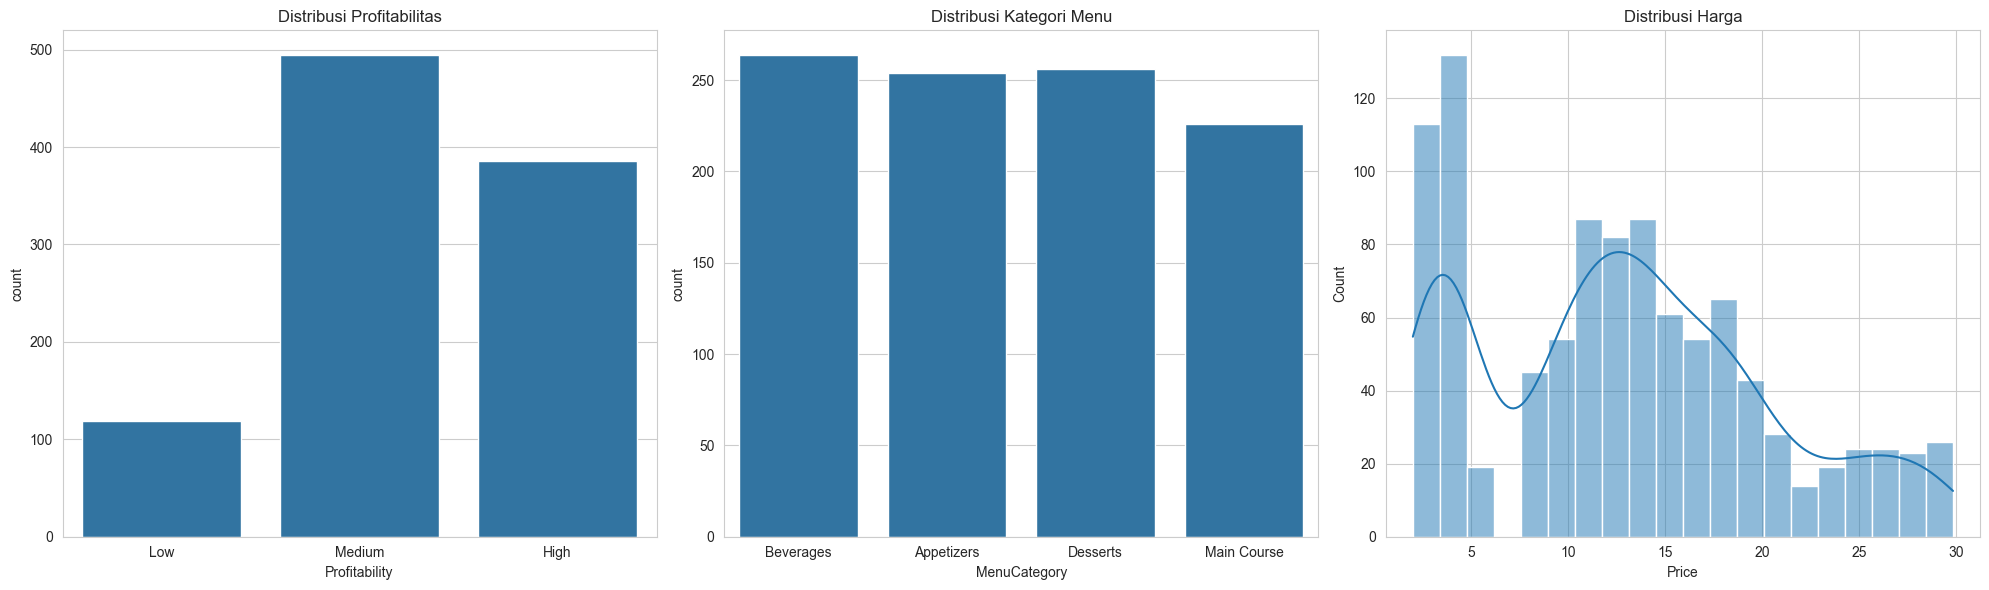

In [2]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
sns.countplot(data=df, x='Profitability', order=['Low', 'Medium', 'High'], ax=axes[0])
axes[0].set_title('Distribusi Profitabilitas')

sns.countplot(data=df, x='MenuCategory', ax=axes[1])
axes[1].set_title('Distribusi Kategori Menu')

sns.histplot(df['Price'], bins=20, kde=True, ax=axes[2])
axes[2].set_title('Distribusi Harga')

plt.tight_layout()
plt.show()

Mengecek Missing Values


In [9]:
missing_values = df.isnull().sum()
missing_values[missing_values > 0]

Series([], dtype: int64)

## Tahap 2: Pra-pemrosesan Data

- **Penghapusan Fitur**: `RestaurantID` dihapus.
- **Encoding**: Fitur kategorikal diubah menjadi numerik menggunakan `LabelEncoder`.
- **Pembagian Data**: Dataset dibagi menjadi data latih (70%) dan data uji (30%).

In [11]:
df_processed = df.drop('RestaurantID', axis=1)

encoders = {}
for col in ['MenuCategory', 'MenuItem', 'Ingredients', 'Profitability']:
    le = LabelEncoder()
    df_processed[col] = le.fit_transform(df_processed[col])
    encoders[col] = le

X = df_processed.drop('Profitability', axis=1)
y = df_processed['Profitability']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

## Pelatihan dan Perbandingan Model Awal (Tanpa Tuning)

Tiga model klasifikasi dilatih menggunakan parameter default untuk menetapkan performa dasar (*baseline*). Model yang dipakai adalah SVC, RandomForest, dan KNN.

--- SVC (Baseline) ---
Akurasi: 0.8167
              precision    recall  f1-score   support

        High       0.87      0.93      0.90       116
         Low       0.00      0.00      0.00        36
      Medium       0.78      0.93      0.85       148

    accuracy                           0.82       300
   macro avg       0.55      0.62      0.58       300
weighted avg       0.72      0.82      0.77       300

--- RandomForest (Baseline) ---
Akurasi: 0.8700
              precision    recall  f1-score   support

        High       0.88      0.85      0.87       116
         Low       0.67      0.67      0.67        36
      Medium       0.91      0.93      0.92       148

    accuracy                           0.87       300
   macro avg       0.82      0.82      0.82       300
weighted avg       0.87      0.87      0.87       300

--- KNN (Baseline) ---
Akurasi: 0.9000
              precision    recall  f1-score   support

        High       0.91      0.92      0.91       116
   

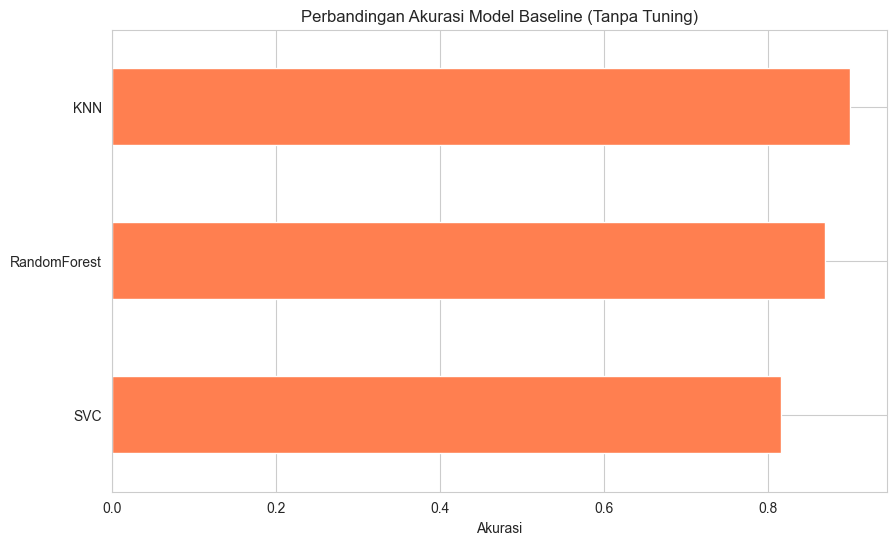

In [4]:
models = {
    'SVC': SVC(),
    'RandomForest': RandomForestClassifier(random_state=42),
    'KNN': KNeighborsClassifier()
}

results_baseline = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results_baseline[name] = accuracy
    print(f'--- {name} (Baseline) ---\nAkurasi: {accuracy:.4f}')
    print(classification_report(y_test, y_pred, target_names=encoders['Profitability'].classes_))

# Visualisasi Baseline
plt.figure(figsize=(10, 6))
pd.Series(results_baseline).sort_values().plot(kind='barh', color='coral')
plt.title('Perbandingan Akurasi Model Baseline (Tanpa Tuning)')
plt.xlabel('Akurasi')
plt.show()

## Tahap 3 (Bagian 2): Hyperparameter Tuning dan Cross-Validation

Sekarang, ketiga model dioptimalkan menggunakan `GridSearchCV`. Proses ini secara otomatis melakukan **hyperparameter tuning** dan **cross-validation (cv=5)** untuk menemukan kombinasi parameter terbaik.

In [5]:
models_and_params = {
    'SVC': (SVC(), {'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01], 'kernel': ['rbf']}),
    'RandomForest': (RandomForestClassifier(random_state=42), {'n_estimators': [50, 100], 'max_depth': [5, 10]}),
    'KNN': (KNeighborsClassifier(), {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']})
}

best_estimators = {}
for name, (model, params) in models_and_params.items():
    print(f'--- Tuning {name} ---')
    grid_search = GridSearchCV(model, params, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_estimators[name] = grid_search.best_estimator_
    print(f'Parameter Terbaik: {grid_search.best_params_}')
    print(f'Skor Akurasi CV Terbaik: {grid_search.best_score_:.4f}\n')

--- Tuning SVC ---
Parameter Terbaik: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Skor Akurasi CV Terbaik: 0.9043

--- Tuning RandomForest ---
Parameter Terbaik: {'max_depth': 5, 'n_estimators': 100}
Skor Akurasi CV Terbaik: 0.9129

--- Tuning KNN ---
Parameter Terbaik: {'n_neighbors': 5, 'weights': 'uniform'}
Skor Akurasi CV Terbaik: 0.8986



## Evaluasi Model Hasil Tuning, Visualisasi, dan Interpretasi

--- SVC (Setelah Tuning) ---
Akurasi: 0.9067
              precision    recall  f1-score   support

        High       0.91      0.93      0.92       116
         Low       0.83      0.67      0.74        36
      Medium       0.92      0.95      0.93       148

    accuracy                           0.91       300
   macro avg       0.89      0.85      0.86       300
weighted avg       0.90      0.91      0.90       300

--- RandomForest (Setelah Tuning) ---
Akurasi: 0.9300
              precision    recall  f1-score   support

        High       0.93      0.97      0.95       116
         Low       0.89      0.67      0.76        36
      Medium       0.93      0.97      0.95       148

    accuracy                           0.93       300
   macro avg       0.92      0.87      0.89       300
weighted avg       0.93      0.93      0.93       300

--- KNN (Setelah Tuning) ---
Akurasi: 0.9000
              precision    recall  f1-score   support

        High       0.91      0.92      

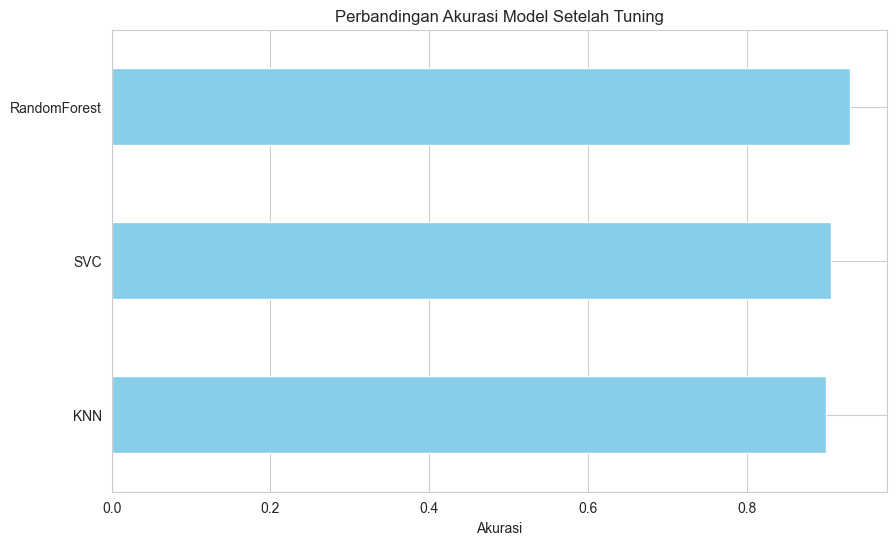

In [6]:
results_tuned = {}
for name, model in best_estimators.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results_tuned[name] = accuracy
    print(f'--- {name} (Setelah Tuning) ---\nAkurasi: {accuracy:.4f}')
    print(classification_report(y_test, y_pred, target_names=encoders['Profitability'].classes_))

# Visualisasi
plt.figure(figsize=(10, 6))
pd.Series(results_tuned).sort_values().plot(kind='barh', color='skyblue')
plt.title('Perbandingan Akurasi Model Setelah Tuning')
plt.xlabel('Akurasi')
plt.show()

**Interpretasi dan Pemilihan Model**

Setelah proses tuning, **RandomForest** menunjukkan performa terbaik dengan akurasi **93%**. Oleh karena itu, model **RandomForest** yang sudah di-tuning dipilih sebagai model terbaik secara keseluruhan.

**Evaluasi Model**

Meskipun model RandomForest yang telah di-tuning memberikan akurasi yang baik, performanya masih dapat ditingkatkan, terutama dalam mengidentifikasi kelas minoritas ('Low') yang jumlah datanya lebih sedikit. Beberapa hal yang mungkin bisa digunakan untuk peningkatan akurasi yaitu:
- Mengimplementasikan model boosting seperti XGBoost yang dikenal memiliki performa tinggi.
- Menerapkan teknik oversampling seperti SMOTE (Synthetic Minority Over-sampling Technique) untuk menyeimbangkan distribusi kelas, sehingga model dapat belajar dari semua kelas secara merata.


## Ekspor Model Terbaik untuk Deployment

Model terbaik, yaitu **RandomForest** yang sudah di-tuning, akan dilatih kembali pada seluruh dataset dan diekspor untuk digunakan oleh aplikasi web.

In [7]:
# Model terbaik adalah RandomForest yang sudah di-tuning
final_model = best_estimators['RandomForest']

# Melatih kembali model terbaik pada seluruh data asli (X dan y)
final_model.fit(X, y)

# Menyimpan model
with open('model.pkl', 'wb') as f:
    pickle.dump(final_model, f)

# Menyimpan encoders
with open('encoders.pkl', 'wb') as f:
    pickle.dump(encoders, f)

# Menyimpan data unik untuk dropdown di HTML
unique_data = {
    'MenuCategory': sorted(df['MenuCategory'].unique()),
    'MenuItem': sorted(df['MenuItem'].unique()),
    'Ingredients': sorted(df['Ingredients'].unique())
}
with open('unique_data.pkl', 'wb') as f:
    pickle.dump(unique_data, f)

print("Model RandomForest terbaik, encoders, dan data unik berhasil diekspor!")

Model RandomForest terbaik, encoders, dan data unik berhasil diekspor!
